# Import

In [1]:
import random
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
import numpy as np
import os
import glob
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, TensorDataset

from tqdm.auto import tqdm

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fp = fm.FontProperties(fname='/home/studio-lab-user/Dacon/tools/NanumFont/NanumGothic.ttf', size=10)
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('device :',device)

device : cuda


<br></br>

# Setting

<br>

## Hyperparameter Setting

In [3]:
CFG = {
    'EPOCHS':128,#1024,
    'PATIENCE':30,
    'LEARNING_RATE':0.05,
    'BATCH_SIZE':16,
    'SEED':42,
}

<br>

## Fixed RandomSeed

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

# seed_everything(CFG['SEED']) # Seed 고정

<br></br>

# Data Pre-processing

In [5]:
import os
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split

class Preprocess:
    def __init__(self, input_paths, label_paths, test_paths):
        self.input_paths = input_paths
        self.label_paths = label_paths
        self.test_paths  = test_paths
        
        self.input, self.label, self.test = None, None, None
        
        self.X_train, self.X_valid = None, None
        self.y_train, self.y_valid = None, None
        self.X, self.y = None, None

        input_fn = []
        label_fn = []
        for input_path, label_path in zip(self.input_paths, self.label_paths):
            case_num = input_path.replace('./data/train_input/CASE_','').replace('.csv','')
            
            input_df = pd.read_csv(input_path)
            label_df = pd.read_csv(label_path)

            input_df = input_df.fillna(0)

            input_df['case_num'] = case_num
            label_df['case_num'] = case_num
            
            input_fn.append(input_df)
            label_fn.append(label_df)
        
        test_fn = []
        for test_path in self.test_paths:
            test_df = pd.read_csv(test_path)
            case_num = test_path.replace('./data/test_input/TEST_','').replace('.csv','')
            
            test_df['case_num'] = case_num
            
            test_fn.append(test_df)
            
        self.input = pd.concat(input_fn,axis=0).sort_values(['case_num','DAT','obs_time'])
        self.label = pd.concat(label_fn,axis=0)
        self.test  = pd.concat(test_fn ,axis=0)
        
    def _data_return(self):
        return self.input,self.label,self.test
            
    def _target_log(self):
        self.label['predicted_weight_g'] = np.log(self.label['predicted_weight_g'])
    
    def _preprocess(self):
        self.input['time'] = [i+1 for i in range(28*24)]*self.input.case_num.nunique()
        self.test ['time'] = [i+1 for i in range(28*24)]*self.test .case_num.nunique()
        
        input_df = []
        test_df  = []
        for case_num in self.input.case_num.unique():
            i_df = self.input[self.input.case_num==case_num]
            t_df = self.test [self.test .case_num==case_num]

            for col in self.input.drop(columns=['case_num','DAT','obs_time','time']).columns:
                i_df[f'{col}_higher_than_yesterday'] = np.where(i_df[col] - i_df[col].shift(1) >0,1,0)
                t_df[f'{col}_higher_than_yesterday'] = np.where(t_df[col] - t_df[col].shift(1) >0,1,0)
            input_df.append(i_df)
            test_df .append(t_df)
            
        self.input = pd.concat(input_df,axis=0)
        self.test  = pd.concat(test_df ,axis=0)
        
        unique_info = self.input.apply(lambda x: x.nunique())
        unique_cols = unique_info[unique_info==1].index.tolist()
        
        self.input = self.input.drop(unique_cols,axis=1)
        self.test  = self.test .drop(unique_cols,axis=1)
        
    # https://dacon.io/competitions/official/236033/talkboard/407304?page=1&dtype=recent
    def _scale_dataset(self,outlier):
        
        minmax_info = {
            'time':[0,28*24],
            '내부온도관측치':[4,40],
            '내부습도관측치':[0,100],
            'co2관측치':[0,1200],
            'ec관측치':[0,8],
            '시간당분무량':[0,3000],
            '일간누적분무량':[0,72000],
            '시간당백색광량':[0,120000],
            '일간누적백색광량':[0,2880000],
            '시간당적색광량':[0,120000],
            '일간누적적색광량':[0,2880000],
            '시간당청색광량':[0,120000],
            '일간누적청색광량':[0,2880000],
            '시간당총광량':[0,120000],
            '일간누적총광량':[0,2880000],
        }
            
        scale_feature = [feature for feature,(min_info,max_info) in minmax_info.items()]
        
        # for train dataset
        for col in scale_feature:
            min_info,max_info = minmax_info[col]
            self.input[col] = (self.input[col]-min_info) / (max_info-min_info)
            
            if outlier=='keep':
                # 0~1을 벗어나는 값 (minmax_info의 범위를 벗어나는 값)은 0,1로 넣기
                # -> 삭제하게되면 24시간의 term이 깨짐
                self.input[col][self.input[col]<0] = 0
                self.input[col][self.input[col]>1] = 1
            elif outlier=='drop':
                self.input[col][(self.input[col]<0)] = np.nan
                self.input[col][(self.input[col]>1)] = np.nan
            
        # for test dataset
        for col in scale_feature:
            min_info,max_info = minmax_info[col]
            self.test[col] = (self.test[col]-min_info) / (max_info-min_info)
            
            if outlier=='keep':
                # 0~1을 벗어나는 값 (minmax_info의 범위를 벗어나는 값)은 0,1로 넣기
                # -> 삭제하게되면 24시간의 term이 깨짐
                self.test[col][self.test[col]<0] = 0
                self.test[col][self.test[col]>1] = 1
            elif outlier=='drop':
                self.test[col][(self.test[col]<0)] = np.nan
                self.test[col][(self.test[col]>1)] = np.nan
        
    def _interaction_term(self):
        num_features = self.input.select_dtypes(exclude=[object]).columns
        num_features = list(set(num_features)-set(['DAT','obs_time']))
        for i in range(len(num_features)):
            for j in range(len(num_features)):
                if i>j:
                    self.input[f'{num_features[i]}*{num_features[j]}'] = self.input[num_features[i]]*self.input[num_features[j]]
                    self.test [f'{num_features[i]}*{num_features[j]}'] = self.test [num_features[i]]*self.test [num_features[j]]

In [6]:
# from scipy.stats import pearsonr

# val_rate = 0.05

# dataset = Preprocess(
#     input_paths = all_input_list,
#     label_paths = all_target_list,
#     test_paths = all_test_list,
# )

# dataset._preprocess()
# dataset._scale_dataset()
# input_df, label_df = dataset._data_return()

# for case_num in tqdm(sorted(input_df.case_num.unique())):

#     input = input_df[input_df.case_num==case_num].drop('case_num',axis=1)
#     label = label_df[label_df.case_num==case_num].drop('case_num',axis=1)

#     fig = plt.figure(figsize=(20,15))
#     nrow = 3
#     ncol = 5

#     iter = 0
#     total = len(input.columns)-3
#     for col in input.columns:
#         if col not in ['time','DAT','obs_time']:
#             iter+=1

#             y1 = input[col]
#             #y1 = (y1-y1.min())/(y1.max()-y1.min())

#             y2 = label['predicted_weight_g']
#             y2 = (y2-y2.min())/(y2.max()-y2.min())

#             y3 = input.groupby('DAT')[col].mean().values

#             corr, pvalue = pearsonr(y2,y3)

#             fig.add_subplot(ncol,nrow,iter)
#             sns.scatterplot(x=input.time  ,y=y1)
#             sns.scatterplot(x=label.DAT*24,y=y2,color='red')
#             sns.lineplot   (x=label.DAT*24,y=y3,color='blue',linestyle='--',alpha=0.7)
#             plt.ylabel('')

#             plt.title(f'{col}(corr={corr:.3f}(pvalue={pvalue:.3f}))',fontproperties=fp)


#     plt.tight_layout()
#     plt.savefig(f'./fig/{case_num}.png',dpi=100)
#     plt.close()

In [7]:
def abline(slope, intercept, color):
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--', color=color)

<br></br>

# Model Define

In [8]:
all_input_list  = sorted(glob.glob('./data/train_input/*.csv'))
all_target_list = sorted(glob.glob('./data/train_target/*.csv'))
all_test_list   = sorted(glob.glob('./data/test_input/*.csv'))

In [21]:
from sklearn.model_selection import train_test_split

# Preprocess Class
dataset = Preprocess(
    input_paths = all_input_list,
    label_paths = all_target_list,
    test_paths = all_test_list,
)

# (1) preprocessing + scaling + interaction term
dataset._preprocess()
# dataset._target_log()
dataset._scale_dataset(outlier='drop')
# dataset._interaction_term()

# (2) Data Return for check
input_df, label_df, test_df = dataset._data_return()

input_df = input_df.drop(['obs_time','time'],axis=1)
label_df = label_df['predicted_weight_g']

input_df = input_df.groupby(['case_num','DAT']).mean().reset_index()#.drop('case_num',axis=1)
test_df  = test_df .groupby(['case_num','DAT']).mean().reset_index()#.drop('case_num',axis=1)

In [22]:
plot_df = pd.concat([input_df,label_df.reset_index(drop=True)],axis=1)
plot_df.head()

,case_num,DAT,내부온도관측치,내부습도관측치,co2관측치,ec관측치,시간당분무량,일간누적분무량,시간당백색광량,일간누적백색광량,시간당적색광량,일간누적적색광량,시간당청색광량,일간누적청색광량,시간당총광량,일간누적총광량,내부온도관측치_higher_than_yesterday,내부습도관측치_higher_than_yesterday,co2관측치_higher_than_yesterday,ec관측치_higher_than_yesterday,시간당분무량_higher_than_yesterday,일간누적분무량_higher_than_yesterday,시간당백색광량_higher_than_yesterday,일간누적백색광량_higher_than_yesterday,시간당적색광량_higher_than_yesterday,일간누적적색광량_higher_than_yesterday,시간당청색광량_higher_than_yesterday,일간누적청색광량_higher_than_yesterday,시간당총광량_higher_than_yesterday,일간누적총광량_higher_than_yesterday,predicted_weight_g
0,01,0,0.639742,0.780613,0.445912,0.174202,0.055018,0.027159,0.088777,0.042402,0.004756,0.002273,0.0,0.0,0.093533,0.044675,0.666667,0.625000,0.416667,0.208333,0.416667,0.791667,0.166667,0.625,0.250000,0.625,0.0,0.0,0.291667,0.625,0.167719
1,01,1,0.653965,0.780750,0.436655,0.173054,0.055286,0.027917,0.089002,0.042502,0.004760,0.002273,0.0,0.0,0.093761,0.044775,0.541667,0.416667,0.541667,0.458333,0.375000,0.750000,0.166667,0.625,0.250000,0.625,0.0,0.0,0.208333,0.625,0.181787
2,01,2,0.629958,0.775900,0.449363,0.174093,0.056857,0.028176,0.088793,0.042391,0.004748,0.002267,0.0,0.0,0.093542,0.044658,0.458333,0.500000,0.583333,0.583333,0.416667,0.750000,0.166667,0.625,0.208333,0.625,0.0,0.0,0.250000,0.625,0.265921
3,01,3,0.615482,0.773661,0.633459,0.175162,0.055286,0.027917,0.089002,0.042502,0.004760,0.002273,0.0,0.0,0.093761,0.044775,0.416667,0.583333,0.583333,0.625000,0.333333,0.750000,0.166667,0.625,0.250000,0.625,0.0,0.0,0.208333,0.625,0.423650
4,01,4,0.625636,0.781317,0.449613,0.175475,0.054660,0.026141,0.088830,0.042400,0.004751,0.002268,0.0,0.0,0.093580,0.044668,0.625000,0.541667,0.416667,0.375000,0.500000,0.750000,0.166667,0.625,0.208333,0.625,0.0,0.0,0.250000,0.625,0.475272


<AxesSubplot: xlabel='case_num', ylabel='predicted_weight_g'>

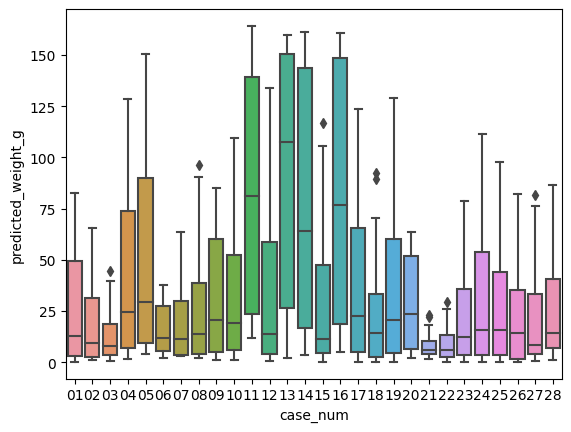

In [23]:
sns.boxplot(x=plot_df.case_num,y=plot_df['predicted_weight_g'])

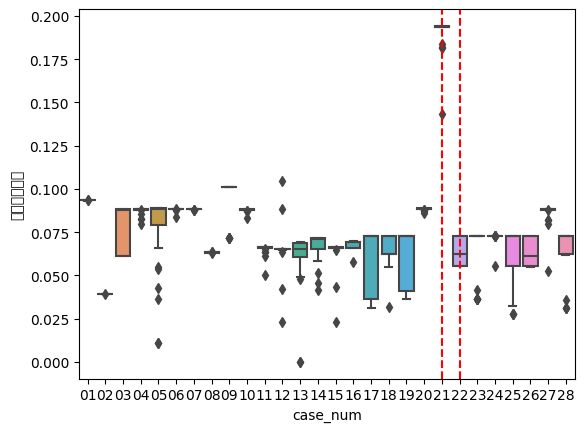

In [38]:
sns.boxplot(x=plot_df.case_num,y=plot_df['시간당총광량'])
plt.axvline(21-1,color='red',linestyle='--')
plt.axvline(22-1,color='red',linestyle='--')

<br>

## train_test_split

### OLS

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(input_df, label_df, test_size=0.05, random_state=42)
print(X_train.shape, X_valid.shape)

In [ ]:
from sklearn.linear_model import LinearRegression, PoissonRegressor

model = LinearRegression()
model.fit(X_train,y_train)

tr_pred = model.predict(X_train)
va_pred = model.predict(X_valid)

# X_train['ols_pred'] = np.exp(X_train['ols_pred'])
# X_valid['ols_pred'] = np.exp(X_valid['ols_pred'])

In [ ]:
from sklearn.metrics import mean_squared_error

tr_mse = np.sqrt(mean_squared_error(tr_pred,y_train))
va_mse = np.sqrt(mean_squared_error(va_pred,y_valid))

print(tr_mse,va_mse)

<br>

### CatBoost

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(input_df, label_df, test_size=0.05, random_state=42)
print(X_train.shape, X_valid.shape)

In [ ]:
from catboost import CatBoostRegressor

model = CatBoostRegressor(iterations=5000,metric_period=1000,random_state=42)
model.fit(X_train,y_train,eval_set=[(X_valid,y_valid)])

tr_pred = model.predict(X_train)
va_pred = model.predict(X_valid)

# X_train['cat_pred'] = np.exp(X_train['cat_pred'])
# X_valid['cat_pred'] = np.exp(X_valid['cat_pred'])

In [ ]:
from sklearn.metrics import mean_squared_error

tr_mse = np.sqrt(mean_squared_error(tr_pred,y_train))
va_mse = np.sqrt(mean_squared_error(va_pred,y_valid))

print(tr_mse,va_mse)

<br></br>

## K-Fold

In [ ]:
test_d = test_df.groupby(['case_num','DAT']).mean().reset_index()

<br>

### OLS

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(input_df,label_df,test_size=0.05)
print(X_train.shape,X_test.shape)

In [ ]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression, PoissonRegressor

X_ref = X_train
y_ref = y_train

tr_preds = []
va_preds = []
te_preds = []
models = []

kf = KFold(n_splits=10, shuffle=True, random_state=42)
for tr_idx, va_idx in kf.split(X_ref):
    X_tr, X_va = X_ref.iloc[tr_idx,:], X_ref.iloc[va_idx,:]
    y_tr, y_va = y_ref.iloc[tr_idx]  , y_ref.iloc[va_idx]
    
    model = LinearRegression()
    model.fit(X_tr,y_tr)
    models.append(model)
    
    tr_pred = model.predict(X_tr)
    va_pred = model.predict(X_va)
    te_pred = model.predict(X_test)
    
    # tr_pred = np.exp(tr_pred)
    # va_pred = np.exp(va_pred)
    
    tr_preds.append(tr_pred)
    va_preds.append(va_pred)
    te_preds.append(te_pred)
    
    tr_rmse = np.sqrt(mean_squared_error(tr_pred,y_tr))
    va_rmse = np.sqrt(mean_squared_error(va_pred,y_va))
    te_rmse = np.sqrt(mean_squared_error(te_pred,y_test))
    print('train : [{:.4f}], validation : [{:.4f}], test : [{:.4f}]'.format(tr_rmse,va_rmse,te_rmse))

In [ ]:
pred = np.mean([model.predict(X_test) for model in models],axis=0) # input_df
true = y_test # label_df

np.sqrt(mean_squared_error(pred,true))

In [ ]:
import seaborn as sns

plt.figure(figsize=(15,7))
sns.scatterplot(x=true,y=pred)
plt.xlabel('actual')
plt.ylabel('prediction')
abline(slope=1,intercept=0,color='red')
plt.show()

In [ ]:
pred = np.mean([model.predict(test_d[X_train.columns]) for model in models],axis=0)
test_d['lr_pred']=pred
test_d.to_csv('./out/test_d.csv',index=False)

<br>

### CatBoost

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(input_df,label_df,test_size=0.05)
print(X_train.shape,X_test.shape)

In [ ]:
from sklearn.model_selection import KFold
from catboost import CatBoostRegressor

X_ref = X_train
y_ref = y_train

tr_preds = []
va_preds = []
te_preds = []
models = []

kf = KFold(n_splits=10, shuffle=True, random_state=42)
pbar = tqdm(kf.split(X_ref),total=10)
for tr_idx, va_idx in pbar:
    X_tr, X_va = X_ref.iloc[tr_idx,:], X_ref.iloc[va_idx,:]
    y_tr, y_va = y_ref.iloc[tr_idx]  , y_ref.iloc[va_idx]
    
    model = CatBoostRegressor(iterations=5000,metric_period=200,random_state=42,verbose=0)
    model.fit(X_tr,y_tr,eval_set=[(X_va,y_va)])
    models.append(model)
    
    tr_pred = model.predict(X_tr)
    va_pred = model.predict(X_va)
    te_pred = model.predict(X_test)
    
    # tr_pred = np.exp(tr_pred)
    # va_pred = np.exp(va_pred)
    
    tr_preds.append(tr_pred)
    va_preds.append(va_pred)
    te_preds.append(te_pred)
    
    tr_rmse = np.sqrt(mean_squared_error(tr_pred,y_tr))
    va_rmse = np.sqrt(mean_squared_error(va_pred,y_va))
    te_rmse = np.sqrt(mean_squared_error(te_pred,y_test))
    print('train : [{:.4f}], validation : [{:.4f}], test : [{:.4f}]'.format(tr_rmse,va_rmse,te_rmse))

In [ ]:
pred = np.mean([model.predict(X_test) for model in models],axis=0) # X_test, input_df
true = y_test # y_test, label_df

np.sqrt(mean_squared_error(pred,true))

In [ ]:
import seaborn as sns

plt.figure(figsize=(15,7))
sns.scatterplot(x=true,y=pred)
plt.xlabel('actual')
plt.ylabel('prediction')
abline(slope=1,intercept=0,color='red')
plt.show()

In [ ]:
pred = np.mean([model.predict(test_d[X_train.columns]) for model in models],axis=0)
test_d['cat_pred']=pred
test_d.to_csv('./out/test_d.csv',index=False)

<br>

### XGBoost

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(input_df,label_df,test_size=0.05)
print(X_train.shape,X_test.shape)

In [ ]:
from sklearn.model_selection import KFold
from xgboost import XGBRegressor

X_ref = X_train
y_ref = y_train

tr_preds = []
va_preds = []
te_preds = []
models = []

kf = KFold(n_splits=10, shuffle=True, random_state=42)
pbar = tqdm(kf.split(X_ref),total=10)
for tr_idx, va_idx in pbar:
    X_tr, X_va = X_ref.iloc[tr_idx,:], X_ref.iloc[va_idx,:]
    y_tr, y_va = y_ref.iloc[tr_idx]  , y_ref.iloc[va_idx]
    
    model = XGBRegressor(n_estimators=5000,random_state=42)
    model.fit(X_tr,y_tr,eval_set=[(X_va,y_va)],verbose=0)
    models.append(model)
    
    tr_pred = model.predict(X_tr)
    va_pred = model.predict(X_va)
    te_pred = model.predict(X_test)
    
    tr_preds.append(tr_pred)
    va_preds.append(va_pred)
    te_preds.append(te_pred)
    
    tr_rmse = np.sqrt(mean_squared_error(tr_pred,y_tr))
    va_rmse = np.sqrt(mean_squared_error(va_pred,y_va))
    te_rmse = np.sqrt(mean_squared_error(te_pred,y_test))
    print('train : [{:.4f}], validation : [{:.4f}], test : [{:.4f}]'.format(tr_rmse,va_rmse,te_rmse))

In [ ]:
pred = np.mean([model.predict(X_test) for model in models],axis=0)
true = y_test

np.sqrt(mean_squared_error(pred,true))

In [ ]:
import seaborn as sns

plt.figure(figsize=(15,7))
sns.scatterplot(x=true,y=pred)
plt.xlabel('actual')
plt.ylabel('prediction')
abline(slope=1,intercept=0,color='red')
plt.show()

In [ ]:
pred = np.mean([model.predict(test_d[X_train.columns]) for model in models],axis=0)
test_d['xgb_pred']=pred
test_d.to_csv('./out/test_d.csv',index=False)

<br>

### LightGBM

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(input_df,label_df,test_size=0.05)
# print(X_train.shape,X_test.shape)

In [ ]:
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor

X_ref = X_train
y_ref = y_train

tr_preds = []
va_preds = []
te_preds = []
models = []

kf = KFold(n_splits=10, shuffle=True, random_state=42)
pbar = tqdm(kf.split(X_ref),total=10)
for tr_idx, va_idx in pbar:
    X_tr, X_va = X_ref.iloc[tr_idx,:], X_ref.iloc[va_idx,:]
    y_tr, y_va = y_ref.iloc[tr_idx]  , y_ref.iloc[va_idx]
    
    model = LGBMRegressor(n_estimators=5000,random_state=42)
    model.fit(X_tr,y_tr,eval_set=[(X_va,y_va)],verbose=0)
    models.append(model)
    
    tr_pred = model.predict(X_tr)
    va_pred = model.predict(X_va)
    te_pred = model.predict(X_test)
    
    # tr_pred = np.exp(tr_pred)
    # va_pred = np.exp(va_pred)
    
    tr_preds.append(tr_pred)
    va_preds.append(va_pred)
    te_preds.append(te_pred)
    
    tr_rmse = np.sqrt(mean_squared_error(tr_pred,y_tr))
    va_rmse = np.sqrt(mean_squared_error(va_pred,y_va))
    te_rmse = np.sqrt(mean_squared_error(te_pred,y_test))
    print('train : [{:.4f}], validation : [{:.4f}], test : [{:.4f}]'.format(tr_rmse,va_rmse,te_rmse))

In [ ]:
pred = np.mean([model.predict(X_test) for model in models],axis=0)
true = y_test

np.sqrt(mean_squared_error(pred,true))

In [ ]:
import seaborn as sns

plt.figure(figsize=(15,7))
sns.scatterplot(x=true,y=pred)
plt.xlabel('actual')
plt.ylabel('prediction')
abline(slope=1,intercept=0,color='red')
plt.show()

In [ ]:
pred = np.mean([model.predict(test_d[X_train.columns]) for model in models],axis=0)
test_d['lgb_pred']=pred
test_d.to_csv('./out/test_d.csv',index=False)

<br></br>

### Ensemble

In [ ]:
test_d['ensemble_pred'] = (test_d['cat_pred']+test_d['xgb_pred']+test_d['lgb_pred'])/3

In [ ]:
case_num='01'

d = test_d[test_d.case_num==case_num]

plot_df = []
for col in ['lr_pred','cat_pred','xgb_pred','lgb_pred','ensemble_pred']:
    plot_df.append(d[['DAT',col]].rename(columns={col:'target'}).assign(grp=col))
plot_df = pd.concat(plot_df,axis=0)    

plt.figure(figsize=(15,7))
sns.lineplot(x=plot_df.DAT,y=plot_df.target,hue=plot_df.grp)
plt.show()

<br></br>

# Inference

In [ ]:
test_d['predicted_weight_g'] = test_d['ensemble_pred']

In [ ]:
os.chdir('/home/studio-lab-user/Dacon/6_상추생육환경생성')

name = 'kf_ensemble'
if not os.path.exists(f'./out/{name}'):
    os.mkdir(f'./out/{name}')

test_d = test_d[['case_num','DAT','predicted_weight_g']]
for case_num in test_d.case_num.unique():
    d = test_d[test_d.case_num==case_num].drop('case_num',axis=1)
    d.to_csv(f'./out/{name}/TEST_{case_num}.csv',index=False)

In [ ]:
import zipfile
os.chdir(f"./out/{name}/")
submission = zipfile.ZipFile(f"../{name}.zip", 'w')
for path in glob.glob('./*.csv'):
    submission.write(path)
submission.close()